In [6]:
library(ggthemes)
library(pryr)
library(tidyverse)
library(scater)
library(idcells)
library(matrixStats)


Attaching package: ‘matrixStats’

The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians

The following object is masked from ‘package:dplyr’:

    count



In [8]:
df_macosko <- readRDS("/home/jovyan/shared_scratch/group1/Macosko/filtered_data.rds")
head(df_macosko)

barcode,umi,alignment,chromosome,count
CAGCACCGCCGC,CCGCGCCC,none-G,*,2
TTCCCAGATCAC,CTGTCTCT,none-G,*,1
TATGCACATCGC,TCTTCCGC,none-G,*,1
CACAGATGGAAG,AAGAAAGA,Sept7,MOUSE_9,6
GGACAGAATCTT,ATACACAA,none-G,*,1
ATAACCAGTGCT,GGGGTTTT,none-G,*,1


In [ ]:
mat_simu_1 <- df2sparse(df_macosko)
dim(mat_simu_1)
set.seed(101)
mat_simu_1_small <- mat_simu_1[, sample(x = 1:ncol(mat_simu_1), size = 10000)]

In [5]:
bcstats_simu_1 <- get_barcode_stats(as.matrix(mat_simu_1))
head(bcstats_simu_1)

total_counts,mean_counts,var_counts,genes_detected,prop_detected
237,0.011028385,0.01891136,187,0.008701722
182,0.008469055,0.01165520,154,0.007166124
225,0.010469986,0.01408368,194,0.009027455
313,0.014564914,0.03008242,228,0.010609586
232,0.010795719,0.01775305,184,0.008562122
271,0.012610517,0.02241065,207,0.009632387


In [6]:
pd <- as(data.frame(barcode = colnames(mat_simu_1_small)), 
         "AnnotatedDataFrame")
rownames(pd) <- colnames(mat_simu_1_small)
fd <- as(data.frame(gene_id = rownames(mat_simu_1_small)), 
         "AnnotatedDataFrame")
rownames(fd) <- rownames(mat_simu_1_small)
sce <- newSCESet(countData = as.matrix(mat_simu_1_small), phenoData = pd,
                 featureData = fd)
ambient_bool <- read_tsv("ambient_genes.txt", col_names = FALSE)
ambient_sparse <- read_tsv("ambient_genes.sparse.txt", col_names = FALSE)
ambient_gene <- read_tsv("ambient_genes.gene_names.txt", col_names = FALSE)
ambient <- bind_cols(ambient_gene, ambient_bool, ambient_sparse)
table(ambient[[1]] %in% featureNames(sce))
sce <- sce[(featureNames(sce) %in% ambient[[1]]),]
ambient <- ambient[ambient[[1]] %in% featureNames(sce),]
fData(sce)$ambient_gene_l2 <- ambient[[2]]
fData(sce)$ambient_gene_l1 <- ambient[[3]]
sce <- sce[rowSums(counts(sce)) > 0.5,]
sce

Parsed with column specification:
cols(
  X1 = col_logical()
)
Parsed with column specification:
cols(
  X1 = col_logical()
)
Parsed with column specification:
cols(
  X1 = col_character()
)



FALSE  TRUE 
  372 21372 

SCESet (storageMode: lockedEnvironment)
assayData: 17325 features, 10000 samples 
  element names: counts, exprs 
protocolData: none
phenoData
  sampleNames: cgacgtgacaataaat-1 aatgcaacgcggtgct-1 ...
    tgactagtactgtaaa-1 (10000 total)
  varLabels: barcode
  varMetadata: labelDescription
featureData
  featureNames: ensg00000000003 ensg00000000419 ... ensg00000273493
    (17325 total)
  fvarLabels: gene_id ambient_gene_l2 ambient_gene_l1
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [15]:
sce <- calculateQCMetrics(sce, 
                          feature_controls = list(ambient = fData(sce)$ambient_gene_l1))

In [16]:
saveRDS(sce, "sceset_simu_1.rds")

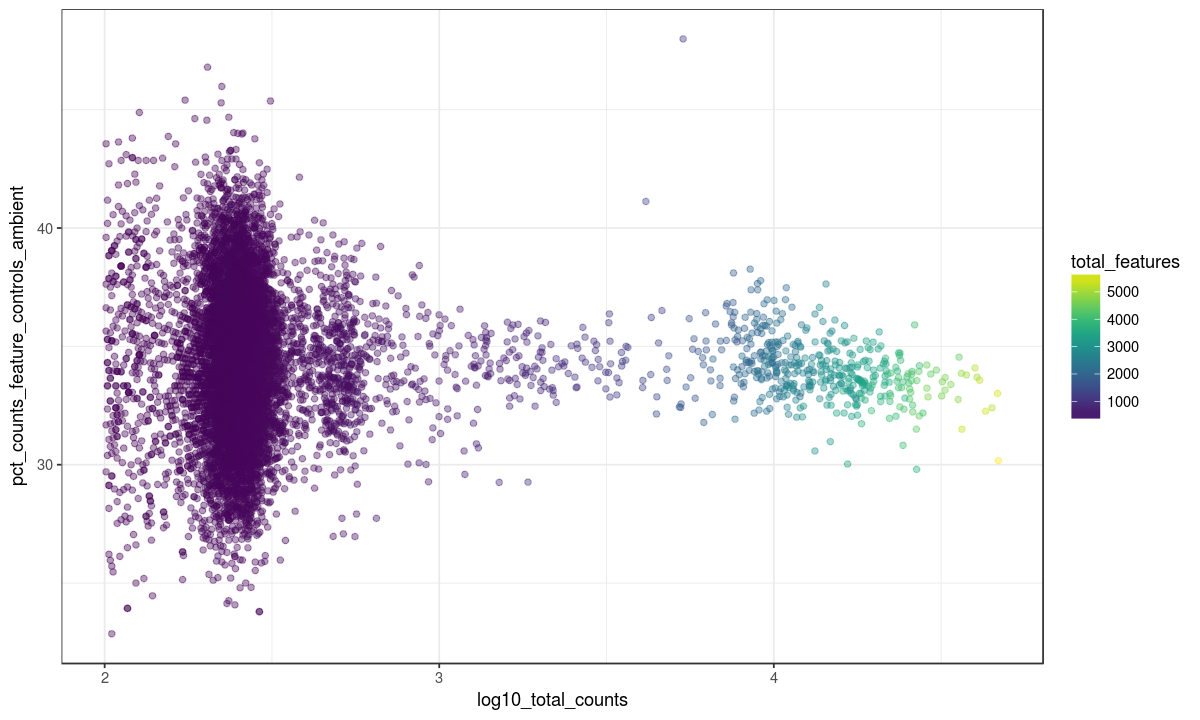

In [14]:
options(repr.plot.width = 10, repr.plot.height=6)
ggplot(pData(sce), aes(x = log10_total_counts, y = pct_counts_feature_controls_ambient, colour = total_features)) +
    geom_point(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()


## Ambient gene analysis

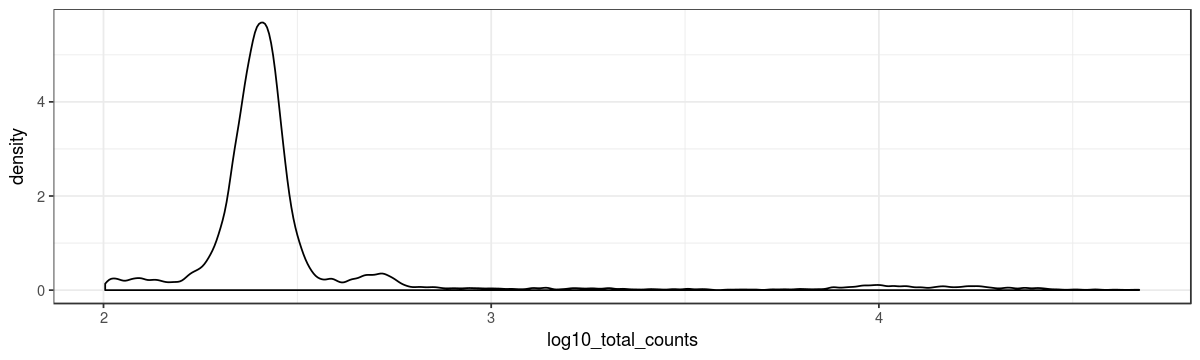

In [19]:
options(repr.plot.width = 10, repr.plot.height=3)
ggplot(pData(sce), aes(x = log10_total_counts)) +
    geom_density(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()

In [35]:
profile_ambient <- function(object, max_umis = 1000) {
    agg_counts <- rowSums(counts(object)[, object$total_counts < max_umis])
    agg_cpm <- agg_counts / sum(agg_counts)
    data_frame(agg_counts, agg_cpm)
}

In [39]:
ambient_profile_500 <- profile_ambient(sce, 500)
ambient_profile_1000 <- profile_ambient(sce, 1000)

In [41]:
table(ambient_profile_500[[1]] == 0)


FALSE  TRUE 
14291  3034 

In [42]:
table(ambient_profile_1000[[1]] == 0)


FALSE  TRUE 
14457  2868 

In [43]:
summary(ambient_profile_1000[["agg_cpm"]])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 4.010e-07 4.011e-06 5.772e-05 2.085e-05 1.723e-02 

In [46]:
summary(ambient_profile_500[["agg_cpm"]])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 4.360e-07 3.922e-06 5.772e-05 2.048e-05 1.724e-02 

In [44]:
sum(ambient_profile_500[[1]])

[1] 2294750

In [45]:
sum(ambient_profile_1000[[1]])

[1] 2493353

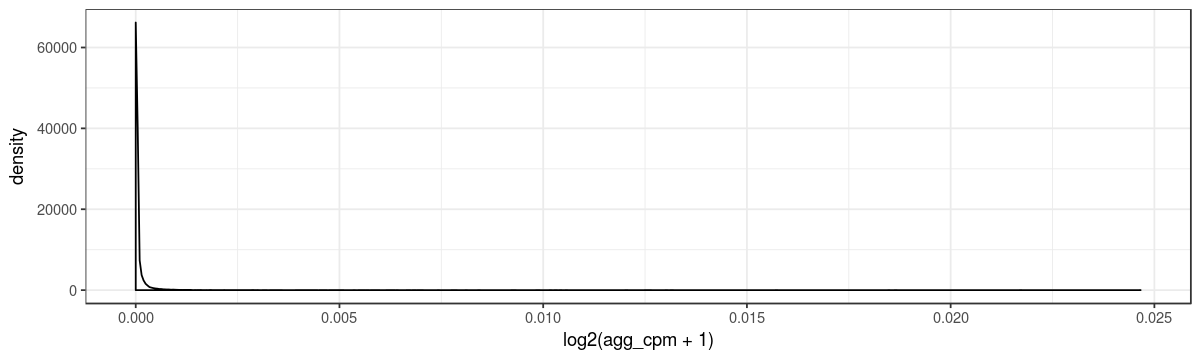

In [47]:
ggplot(ambient_profile_500, aes(x = log2(agg_cpm + 1))) +
    geom_density() + theme_bw()

In [48]:
sce_agg_amb <- sce

In [49]:
sce_agg_amb <- calculateQCMetrics(sce_agg_amb, 
                          feature_controls = list(
                              ambient = ambient_profile_500[[2]] > median(ambient_profile_500[[2]])))

In [56]:
meanvar_df <- data_frame(mean_exprs = rowMeans(exprs(sce)), var_exprs = rowVars(exprs(sce)))

`geom_smooth()` using method = 'gam'


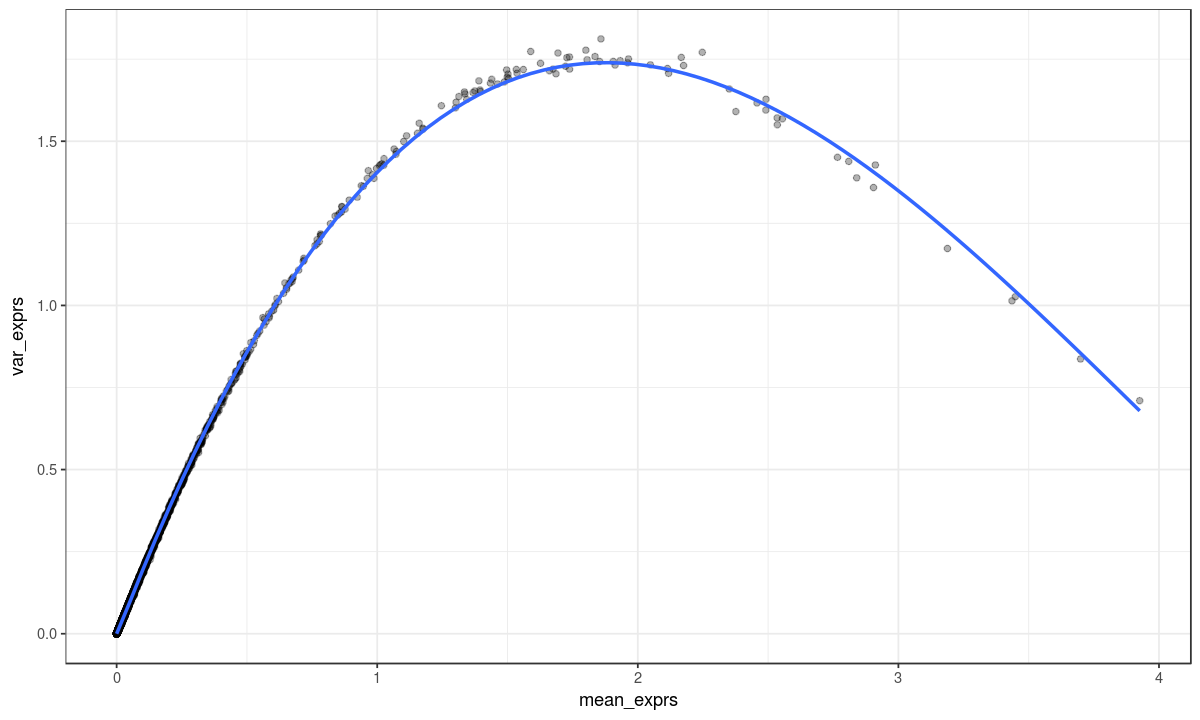

In [57]:
ggplot(meanvar_df, aes(x = mean_exprs, y = var_exprs)) +
    geom_point(alpha = 0.3) + geom_smooth() +
    theme_bw()

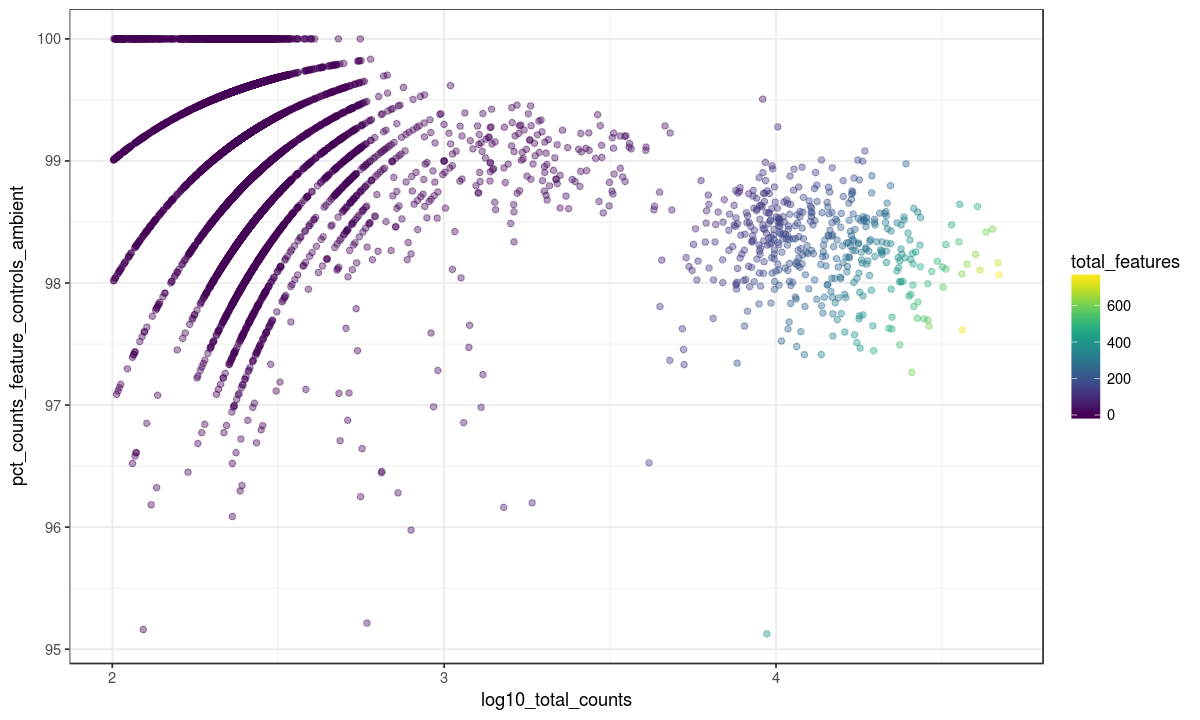

In [50]:
options(repr.plot.width = 10, repr.plot.height=6)
ggplot(pData(sce_agg_amb), aes(x = log10_total_counts, y = pct_counts_feature_controls_ambient, 
                               colour = total_features)) +
    geom_point(alpha = 0.4) +
    theme_bw() + viridis::scale_color_viridis()

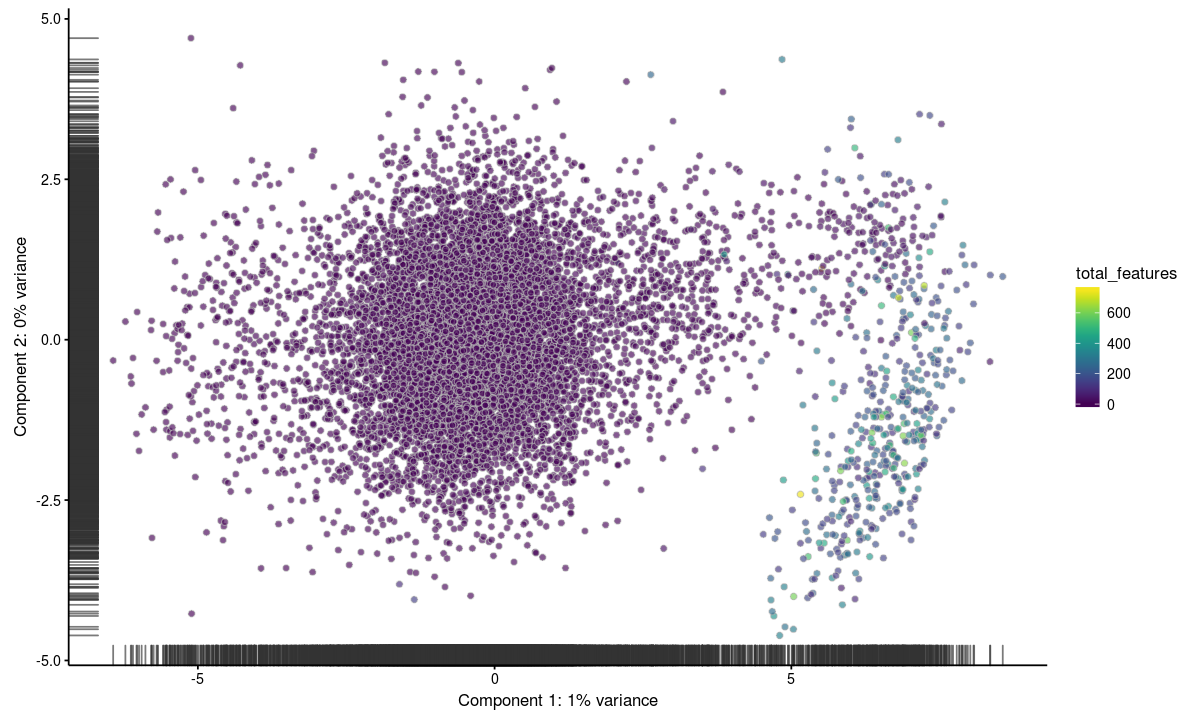

In [51]:
options(repr.plot.width = 10, repr.plot.height=6)
plotPCA(sce_agg_amb[fData(sce_agg_amb)$is_feature_control_ambient,], colour = "total_features")

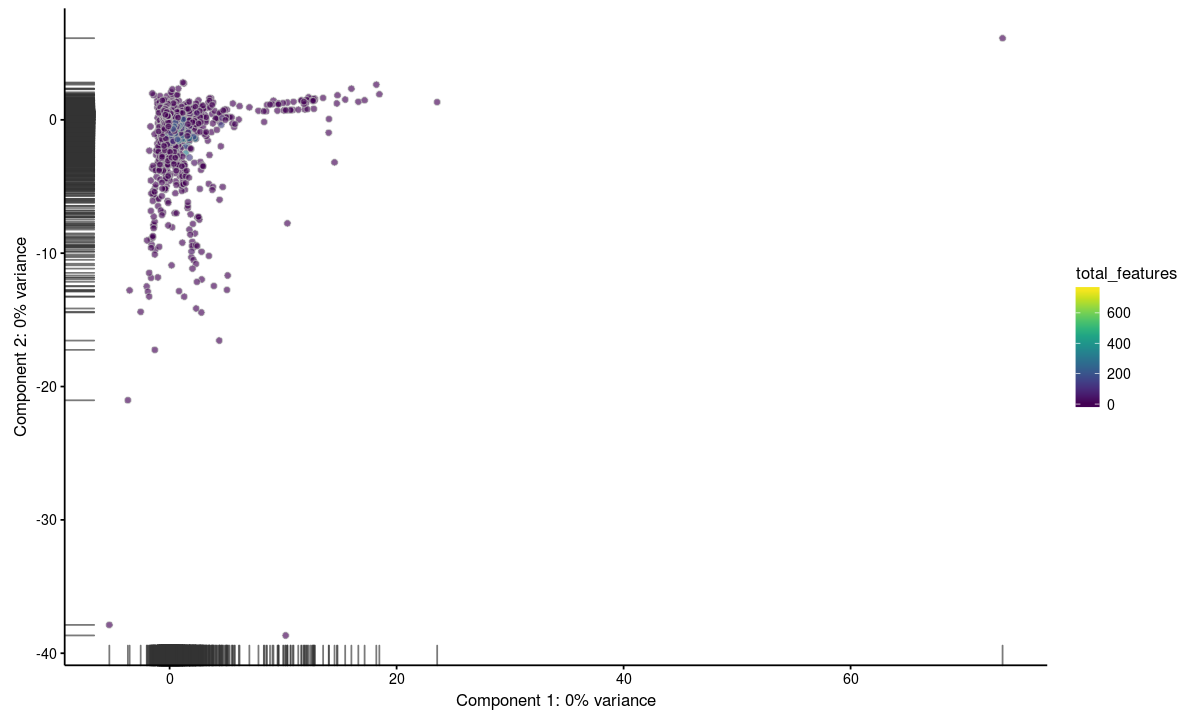

In [52]:
options(repr.plot.width = 10, repr.plot.height=6)
plotPCA(sce_agg_amb[!fData(sce_agg_amb)$is_feature_control_ambient,], colour = "total_features")

In [53]:
summary(colSums(counts(sce_agg_amb)[fData(sce_agg_amb)$is_feature_control_ambient,]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   99.0   227.0   254.0   911.9   284.0 46012.0 

In [54]:
summary(colSums(counts(sce_agg_amb)[!fData(sce_agg_amb)$is_feature_control_ambient,]))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    1.00    2.00   13.69    4.00  907.00 

In [63]:
sce$gini_all_genes <- apply(exprs(sce), 2, Gini)
ubiq_genes <- featureNames(sce)[fData(sce)$n_cells_exprs > 2500]
nonubiq_genes <- featureNames(sce)[fData(sce)$n_cells_exprs < 2500]
sce$gini_ubiq_genes <- apply(exprs(sce)[ubiq_genes,], 2, Gini)
sce$gini_nonubiq_genes <- apply(exprs(sce)[nonubiq_genes,], 2, Gini)
sce$gini_ambient_genes_l1 <- apply(exprs(sce)[fData(sce)$ambient_gene_l1,], 2, Gini)
sce$gini_ambient_genes_l2 <- apply(exprs(sce)[fData(sce)$ambient_gene_l2,], 2, Gini)

ERROR: Error in match.fun(FUN): object 'Gini' not found


## Covariance/distance analysis

In [ ]:
sce_1000 <- sce[fData(sce)$ambient_gene_l1, 1:1000]
d1 <- dist(as.matrix(t(exprs(sce_1000))))
mds1 <- cmdscale(d1, k = 3)
redDim(sce_1000) <- mds1
plotReducedDim(sce_1000, colour_by = "total_features")

In [ ]:
d2 <- dist(as.matrix(t(exprs(sce_1000))), method = "canberra")
mds2 <- cmdscale(d2, k = 3)
redDim(sce_1000) <- mds2
plotReducedDim(sce_1000, colour_by = "total_features")

In [ ]:
d3 <- dist(as.matrix(t(exprs(sce_1000))), method = "binary")
mds3 <- cmdscale(d3, k = 3)
redDim(sce_1000) <- mds3
plotReducedDim(sce_1000, colour_by = "total_features")

In [ ]:
sce_good <- sce[, sce$total_features > 1000 & sce$total_counts > 2000]
sce_bad <- sce[, sce$total_features < 1000 | sce$total_counts < 2000]
bad_profile_exprs <- matrixStats::rowMedians(exprs(sce_bad))
bad_profile_counts <- matrixStats::rowMedians(counts(sce_bad))

In [58]:
score1 <- cor(exprs(sce), log2(ambient_profile_500[[2]] + 1), method = "pearson")
score2 <- cor(exprs(sce), log2(ambient_profile_500[[2]] + 1), method = "spearman")


In [60]:
sce$bad_score_exprs_pears <- score1[, 1]
sce$bad_score_exprs_spear <- score2[, 1]

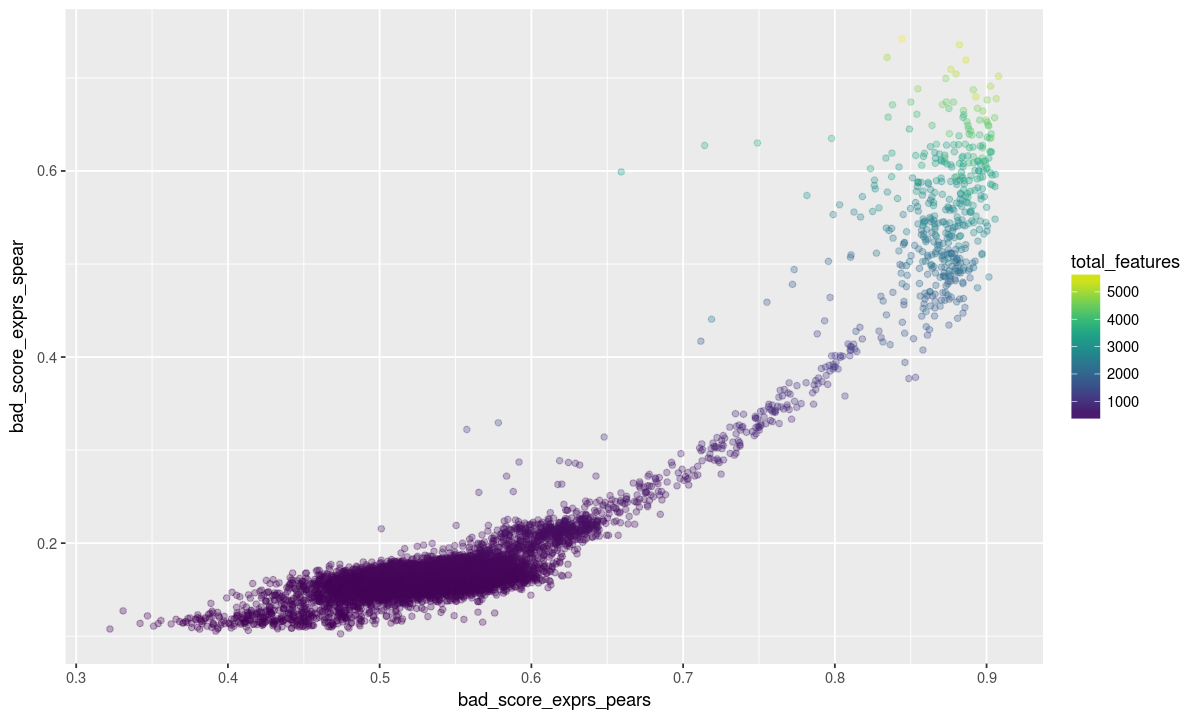

In [62]:
ggplot(pData(sce), aes(x = bad_score_exprs_pears, y = bad_score_exprs_spear, colour = total_features)) +
    geom_point(alpha = 0.3) + viridis::scale_color_viridis()